In [ ]:
import pandas as pd
import numpy as np
import random
import os

def load_data(timestamp_files):
    """
    Loads the option data for each timestamp from the provided CSV files and ensures the correct data types.
    """
    data = {}
    for t, file in enumerate(timestamp_files):
        data[t] = pd.read_csv(file)  # Load data from CSV file

        # Ensure 'Close  ' and 'Underlying Value' columns are numeric (convert to float)
        data[t]['Close'] = pd.to_numeric(data[t]['Close'], errors='coerce')
        data[t]['Underlying Value'] = pd.to_numeric(data[t]['Underlying Value'], errors='coerce')

        # Add a 'used' column to track if an option is used in a time series
        data[t]['used'] = False

    return data

def select_next_option(current_price, next_timestamp_data, percentage_range=(-0.01, 0.05)):
    """
    Selects the next option randomly within a specified price range.

    Parameters:
    - current_price: The current option price in the time series.
    - next_timestamp_data: DataFrame of the next timestamp options.
    - percentage_range: Tuple representing the percentage range (min, max) to limit selection.

    Returns:
    - selected_option: The selected option (if any) within the range.
    """
    min_price = current_price * (1 + percentage_range[0])
    max_price = current_price * (1 + percentage_range[1])

    # Filter next timestamp data for options within the range and not yet used
    candidates = next_timestamp_data[
        (next_timestamp_data['Close'] >= min_price) &
        (next_timestamp_data['Close'] <= max_price) &
        (next_timestamp_data['used'] == False)
    ]

    if not candidates.empty:
        selected_option = candidates.sample(n=1)  # Randomly select one from the filtered options
        return selected_option.iloc[0]
    else:
        return None  # No option found in the range



def create_time_series(data, percentage_range=(-0.01, 0.05)):
    """
    Creates time series by connecting options across timestamps.

    Parameters:
    - data: Dictionary of DataFrames for each timestamp.
    - percentage_range: Range of price movement allowed for selecting the next option.

    Returns:
    - time_series_list: List of time series created.
    - underlying_series_list: List of corresponding underlying value time series.
    - time_to_maturity_series_list: List of corresponding time-to-maturity series.
    - strike_price_series_list: List of corresponding strike price series.
    """
    time_series_list = []
    underlying_series_list = []
    time_to_maturity_series_list = []
    strike_price_series_list = []

    for t in range(len(data) - 1):  # Iterate through timestamps
        for i, option in data[t].iterrows():
            if not option['used']:  # If option is not used in any time series
                time_series = [option['Close']]  # Start new time series for option prices
                underlying_series = [option['Underlying Value']]  # Start new series for underlying values
                time_to_maturity_series = [option['Time to Maturity']]  # Start new series for time to maturity
                strike_price_series = [option['Strike Price']]  # Start new series for strike price
                data[t].at[i, 'used'] = True  # Mark as used

                current_price = option['Close']
                current_underlying = option['Underlying Value']
                current_time_to_maturity = option['Time to Maturity']
                current_strike_price = option['Strike Price']

                for next_t in range(t+1, len(data)):
                    next_option = select_next_option(current_price, data[next_t], percentage_range)
                    if next_option is not None:
                        time_series.append(next_option['Close'])
                        underlying_series.append(next_option['Underlying Value'])
                        time_to_maturity_series.append(next_option['Time to Maturity'])
                        strike_price_series.append(next_option['Strike Price'])
                        current_price = next_option['Close']
                        current_underlying = next_option['Underlying Value']
                        current_time_to_maturity = next_option['Time to Maturity']
                        current_strike_price = next_option['Strike Price']
                        data[next_t].at[next_option.name, 'used'] = True  # Mark as used
                    else:
                        break  # No more options within range, stop this time series

                time_series_list.append(time_series)  # Save the constructed time series
                underlying_series_list.append(underlying_series)  # Save the corresponding underlying series
                time_to_maturity_series_list.append(time_to_maturity_series)  # Save the time to maturity series
                strike_price_series_list.append(strike_price_series)  # Save the strike price series

    return time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list

def extend_time_series(time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list, target_length=75):
    """
    Extends the time series to a target length by inserting random values.

    Parameters:
    - time_series_list: List of time series to be extended.
    - underlying_series_list: List of corresponding underlying value time series.
    - time_to_maturity_series_list: List of corresponding time to maturity series.
    - strike_price_series_list: List of corresponding strike price series.
    - target_length: The desired final length of each time series.

    Returns:
    - extended_series_list: List of extended time series.
    - extended_underlying_list: List of extended underlying value series.
    - extended_time_to_maturity_list: List of extended time to maturity series.
    - extended_strike_price_list: List of extended strike price series.
    """
    extended_series_list = []
    extended_underlying_list = []
    extended_time_to_maturity_list = []
    extended_strike_price_list = []

    for ts, us, tm, sp in zip(time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list):
        if len(ts) >= 7:
            while len(ts) < target_length:
                # Randomly select two distinct points in the time series
                idx1, idx2 = random.sample(range(len(ts)), 2)
                idx1, idx2 = sorted([idx1, idx2])  # Ensure idx1 < idx2

                # Get the values at these points
                val1 = ts[idx1]
                val2 = ts[idx2]

                # Get the underlying values at these points
                spot1 = us[idx1]
                spot2 = us[idx2]

                # Get the time to maturity at these points
                time1 = tm[idx1]
                time2 = tm[idx2]

                # Get the strike prices at these points
                strike1 = sp[idx1]
                strike2 = sp[idx2]

                # Determine the range for the new option price value
                min_value = min(val1, val2) * 0.98  # -2% of the smaller one
                max_value = max(val1, val2) * 1.02  # +2% of the greater one

                # Determine the range for the new underlying value
                min_underlying_value = min(spot1, spot2) * 0.98  # -2% of the smaller spot price
                max_underlying_value = max(spot1, spot2) * 1.02  # +2% of the greater spot price

                # Determine the range for the new time to maturity
                new_time_to_maturity = random.uniform(min(time1, time2), max(time1, time2))

                # Determine the range for the new strike price
                min_strike_price = min(strike1, strike2) * 0.98  # -2% of the lower strike price
                max_strike_price = max(strike1, strike2) * 1.02  # +2% of the higher strike price
                new_strike_price = random.uniform(min_strike_price, max_strike_price)

                # Generate random values in the respective ranges
                new_value = random.uniform(min_value, max_value)
                new_underlying_value = random.uniform(min_underlying_value, max_underlying_value)

                # Insert the new values at a random position between idx1 and idx2
                insert_position = random.randint(idx1 + 1, idx2)  # Must be between the two points
                ts.insert(insert_position, new_value)
                us.insert(insert_position, new_underlying_value)
                tm.insert(insert_position, new_time_to_maturity)
                sp.insert(insert_position, new_strike_price)

            extended_series_list.append(ts)  # Append the extended series
            extended_underlying_list.append(us)  # Append the extended underlying series
            extended_time_to_maturity_list.append(tm)  # Append the extended time to maturity series
            extended_strike_price_list.append(sp)  # Append the extended strike price series

    return extended_series_list, extended_underlying_list, extended_time_to_maturity_list, extended_strike_price_list

# Example usage:

# Generate file paths for all 28 timestamps
timestamp_files = [f'/content/timestamp_{i}.csv' for i in range(24)]

# Load the data from the files
data = load_data(timestamp_files)

# Create the time series with the heuristic range of -5% to +15%
time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list = create_time_series(data, percentage_range=(-0.01, 0.05))

# Extend the time series
extended_time_series, extended_underlying_series, extended_time_to_maturity_series, extended_strike_price_series = extend_time_series(
    time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list)

# Output the generated time series and corresponding underlying, time-to-maturity, and strike-price series
for idx, (ts, us, tm, sp) in enumerate(zip(extended_time_series, extended_underlying_series, extended_time_to_maturity_series, extended_strike_price_series)):
    print(f"Time Series {idx+1}: {ts}")
    print(f"Underlying Value Series {idx+1}: {us}")
    print(f"Time to Maturity Series {idx+1}: {tm}")
    print(f"Strike Price Series {idx+1}: {sp}")

Time Series 1: [7917.15, 7844.503361308065, 7917.15, 7917.15, 7976.801139987677, 7917.15, 7917.15, 7794.465999154111, 7944.824033307262, 7917.15, 7917.15, 7893.610377629473, 7917.15, 8233.7770640193, 8178.864678365405, 7926.492612805847, 7999.812365597247, 7946.731584118998, 8392.35575921931, 7985.247503149335, 8015.752668213557, 8059.864031871454, 7919.321959516242, 7895.006447667337, 7842.705886536044, 8033.573835976556, 7828.836770823896, 7917.15, 7878.484506758058, 7917.15, 8113.047337446589, 7898.274484495919, 8307.448929624177, 8015.153510752646, 8105.232711207944, 7952.7417589270935, 7750.015618698607, 7821.047957115394, 8109.670129417931, 7917.15, 8335.911999531827, 7729.635714781222, 8040.222672822062, 7951.08086737624, 7917.15, 8004.278414110943, 8330.651724854335, 8245.331085199554, 7917.15, 8065.815567036387, 7976.9749608496095, 7917.15, 8180.218874547133, 8265.181811563747, 8033.413291015492, 7917.15, 7896.366979330958, 8094.718666359826, 7878.973988020848, 7917.15, 8120.4

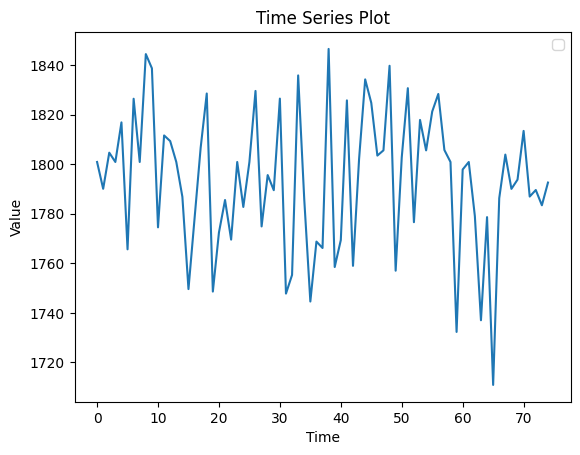

In [ ]:
# prompt: plot all of these time series together

import matplotlib.pyplot as plt

plt.plot(extended_time_series[22])

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
!pip install tsfel
import tsfel  # Time Series Feature Extraction Library


def generate_heston_data(n_samples=len(extended_time_series), time_steps=100):

    params = np.zeros((n_samples, 5))  # alpha, eta, nu, sigma_nu, rho

    # Randomized parameter generation for Heston model
    for i in range(n_samples):
        alpha = np.random.uniform(0.1, 1)  # keep same range
        eta = np.random.uniform(0.01, 0.05)  # reduced range and magnitude
        nu = np.random.uniform(0.01, 0.05)  # reduced range and magnitude
        sigma_nu = np.random.uniform(0.1, 0.2)  # tighter range
        rho = np.random.uniform(-1, 0.2)  # more negative, avoiding extremes
        params[i] = [alpha, eta, nu, sigma_nu, rho]

        # Generate a time-series path for the Heston model (simplified)

    return params

params = generate_heston_data()

X_train, X_test, time_train, time_test, underlying_train, underlying_test,strike_train, strike_test, params_train, params_test = train_test_split(extended_time_series, extended_time_to_maturity_series, extended_underlying_series, extended_strike_price_series, params, test_size=0.2, random_state=42)

# Advanced Feature Extraction using TSFEL (Time Series Feature Extraction Library)
cfg = tsfel.get_features_by_domain("statistical")
X_train_features = tsfel.time_series_features_extractor(cfg, X_train)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test)


<ipython-input-6-d7fbef472e6b>:35: UserWarning: Using default sampling frequency set in configuration file.
  X_train_features = tsfel.time_series_features_extractor(cfg, X_train)


<ipython-input-6-d7fbef472e6b>:36: UserWarning: Using default sampling frequency set in configuration file.
  X_test_features = tsfel.time_series_features_extractor(cfg, X_test)


In [ ]:
# prompt: appropriately scale these features as they are very large

from sklearn.preprocessing import StandardScaler

# Assuming X_train_features and X_test_features are your feature matrices
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)


def build_deeponet():
    # Branch network hyperparameters
    branch_neurons_1 = 128
    branch_neurons_2 = 64
    branch_dropout = 0.3

    # Trunk network hyperparameters
    trunk_neurons_1 = 64

    # Branch Network
    branch_input = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(branch_neurons_1, activation='relu')(branch_input)
    x = Dropout(branch_dropout)(x)
    x = Dense(branch_neurons_2, activation='relu')(x)
    x = Dropout(branch_dropout)(x)
    branch_model = Model(branch_input, x)

    # Trunk Network
    trunk_input = Input(shape=(1,))
    x = Dense(trunk_neurons_1, activation='relu')(trunk_input)
    trunk_model = Model(trunk_input, x)

    # Combine branch and trunk outputs
    combined = concatenate([branch_model.output, trunk_model.output])
    final_output = Dense(128, activation='relu')(combined)
    final_output = Dropout(branch_dropout)(final_output)

    # Output layer: predicting 5 Heston parameters
    final_output = Dense(5, activation='linear')(final_output)

    # Build and compile the model
    model = Model([branch_model.input, trunk_model.input], final_output)

    # Add gradient clipping for stability
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0), loss='mse')

    return model


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


def safe_model_fit(model, X_train, params_train, callbacks):
    try:
        history = model.fit(
            [X_train_scaled, np.ones((X_train_scaled.shape[0], 1))], params_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=callbacks
        )
        return history
    except Exception as e:
        print(f"Model fitting failed with error: {e}")
        return None


def ensemble_models(models, X_test_scaled):
    preds = np.zeros((len(X_test_scaled), 5))  # 5 parameters to predict
    for model in models:
        preds += model.predict([X_test_scaled, np.ones((X_test_scaled.shape[0], 1))])
    return preds / len(models)  # Average predictions


ensemble = []
for _ in range(5):  # Build 5 models with slight variations
    model = build_deeponet()
    safe_model_fit(model, X_train, params_train, callbacks)
    ensemble.append(model)

# Perform ensemble prediction
ensemble_predictions = ensemble_models(ensemble, X_test_scaled)

# Evaluate ensemble model (for illustration, compare against actual test params)
ensemble_loss = np.mean((ensemble_predictions - params_test) ** 2)
print(f'Ensemble Model MSE: {ensemble_loss}')





Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - loss: 0.1646 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.1330 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1278 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0889 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1057 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0890 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0687 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0707 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0783 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 10/50
2/2 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Ensemble Model MSE: 0.058119747794298


MSE for each parameter:
alpha: 0.13660287357442544
eta: 0.0013849870433253477
nu: 0.005249491501108372
sigma_nu: 0.021333568271812823
rho: 0.12602781858081805

Example 1:
Predicted Parameters: [ 0.21909427 -0.00530316 -0.01326952  0.05726505 -0.13996443]
True Parameters: [0.59953662 0.01302437 0.01208245 0.17612858 0.08083558]

Example 2:
Predicted Parameters: [ 0.49247436  0.05045792  0.00753423 -0.04130141 -0.10699682]
True Parameters: [ 0.63487031  0.03257204  0.017028    0.19889489 -0.17190321]

Example 3:
Predicted Parameters: [ 0.20704391  0.00290556 -0.02332278 -0.00287962 -0.19948362]
True Parameters: [ 0.16022833  0.02957875  0.02914519  0.12366169 -0.34573959]

Example 4:
Predicted Parameters: [ 0.33981585  0.02175141  0.03056169  0.00377974 -0.06449467]
True Parameters: [0.61762974 0.01195803 0.01510666 0.12405499 0.08758006]

Example 5:
Predicted Parameters: [ 0.48548874  0.06800972  0.02714176 -0.04561631 -0.11951947]
True Parameters: [ 0.74344407  0.02053999  0.02472653  

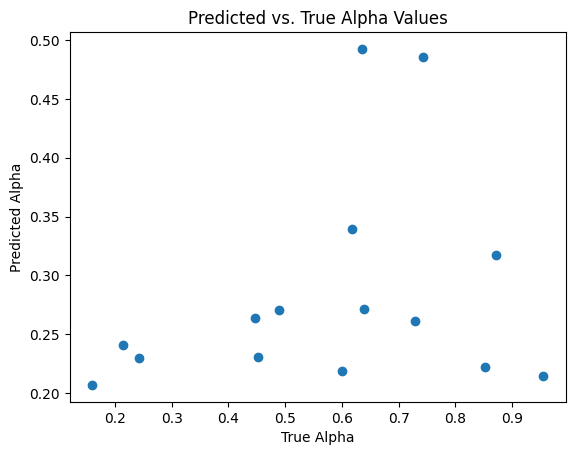

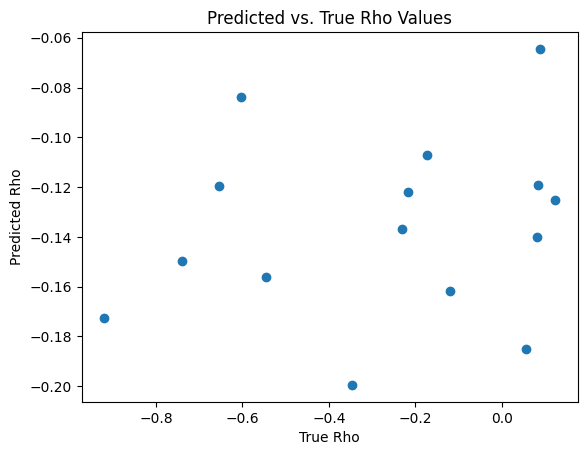

In [ ]:
mse_per_parameter = np.mean((ensemble_predictions - params_test) ** 2, axis=0)

# Print the MSE for each parameter
print("MSE for each parameter:")
parameter_names = ['alpha', 'eta', 'nu', 'sigma_nu', 'rho']
for i, mse in enumerate(mse_per_parameter):
    print(f"{parameter_names[i]}: {mse}")


# Optionally, you can also print some example predictions and their corresponding true values
for i in range(len(ensemble_predictions)):  # Print results for the first 5 test examples
    print(f"\nExample {i+1}:")
    print("Predicted Parameters:", ensemble_predictions[i])
    print("True Parameters:", params_test[i])

# Example:  Visualize the predicted vs. true values for a specific parameter (e.g., alpha)
plt.scatter(params_test[:, 0], ensemble_predictions[:, 0])  # alpha vs. predicted alpha
plt.xlabel("True Alpha")
plt.ylabel("Predicted Alpha")
plt.title("Predicted vs. True Alpha Values")
plt.show()

plt.scatter(params_test[:, 4], ensemble_predictions[:, 4])  # alpha vs. predicted alpha
plt.xlabel("True Rho")
plt.ylabel("Predicted Rho")
plt.title("Predicted vs. True Rho Values")
plt.show()

In [ ]:
import random
import numpy as np

random_index = random.randint(0, len(X_test) - 1)
random_time_series = X_test[random_index]
time_to_maturities = time_test[random_index]
random_underlying = underlying_test[random_index]
random_strike = strike_test[random_index]
predicted_params = ensemble_predictions[random_index]
alpha, eta, nu, sigma_nu, rho = predicted_params


n = len(random_time_series)
data = []
for i in range(n):
    d = {'price': random_time_series[i], 'S0': random_underlying[i], 'K': random_strike[i], 'tau': time_to_maturities[i]}
    data.append(d)

print(data)




[{'price': 5051.1, 'S0': 53103.7, 'K': 48500.0, 'tau': 0.0931506849315068}, {'price': 5051.1, 'S0': 52660.35, 'K': 48500.0, 'tau': 0.0904109589041095}, {'price': 5063.797652995685, 'S0': 51154.74285144447, 'K': 49164.28909152098, 'tau': 0.09038499669075395}, {'price': 5081.523866343433, 'S0': 51665.33722219987, 'K': 48087.70881170963, 'tau': 0.08993893287792669}, {'price': 4978.475340563395, 'S0': 51762.42280941958, 'K': 48699.44892754167, 'tau': 0.09029100670216139}, {'price': 5051.1, 'S0': 52425.8, 'K': 48500.0, 'tau': 0.0821917808219178}, {'price': 5072.80474587717, 'S0': 52797.01403360824, 'K': 47179.824406721, 'tau': 0.08876062539297196}, {'price': 5167.2623953129, 'S0': 53852.678738024035, 'K': 46422.144888182724, 'tau': 0.0724919085115689}, {'price': 5051.1, 'S0': 52568.8, 'K': 48500.0, 'tau': 0.0794520547945205}, {'price': 5232.906028841235, 'S0': 51865.94922520235, 'K': 49316.3167347583, 'tau': 0.08296273870235314}, {'price': 5008.310716583587, 'S0': 51509.425764284795, 'K': 4

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import math

# Heston model pricer and characteristic function definitions
# def heston_characteristic_function(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum):
#     """
#     Compute the characteristic function for the Heston model.
#     """
#     i = complex(0, 1)
#     x = np.log(S0)
#     if Pnum == 1:
#         u = 0.5
#         b = kappa - rho * sigma
#     else:
#         u = -0.5
#         b = kappa

#     d = np.sqrt((rho * sigma * i * phi - b)**2 - (sigma**2) * (2 * u * i * phi - phi**2))
#     #print(d)
#     g = (b - rho * sigma * i * phi + d) / (b - rho * sigma * i * phi - d)

#     C = r * i * phi * tau + (kappa * theta / sigma**2) * ((b - rho * sigma * i * phi + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
#     D = (b - rho * sigma * i * phi + d) / sigma**2 * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))

#     return np.exp(C + D * v0 + i * phi * x)

def heston_characteristic_function(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum):
    i = complex(0, 1)
    x = np.log(S0)
    if Pnum == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa

    d = np.sqrt((rho * sigma * i * phi - b)**2 - (sigma**2) * (2 * u * i * phi - phi**2))
    #print(d)
    g = (b - rho * sigma * i * phi + d) / (b - rho * sigma * i * phi - d)

    C = r * i * phi * tau + (kappa * theta / sigma**2) * ((b - rho * sigma * i * phi + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))

    D = ((b - rho * sigma * i * phi + d) / sigma**2) * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))
    if math.isnan(C.real) and math.isnan(C.imag) and math.isnan(D.real) and math.isnan(D.imag):
        print("C, D is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001
    elif math.isnan(D.real) and math.isnan(D.imag):
        print("D is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001

    elif math.isnan(C.real) and math.isnan(C.imag):
        print("C is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001


    return np.exp(C + D * v0 + i * phi * x)



def heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, Pnum):
    """
    Compute the integrand for the Heston price calculation.
    """
    i = complex(0, 1)
    char_func = heston_characteristic_function(phi - (i * 1e-5), kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
    payoff = np.exp(-i * phi * np.log(K)) / (i * phi)

    return np.real(np.exp(-i * phi * np.log(K)) * char_func / (i * phi))

def heston_price(S0, K, tau, r, q, kappa, theta, sigma, rho, v0):
    """
    Computes the Heston price of a European Call option.
    """
    integrand_P1 = lambda phi: heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, 1)
    integrand_P2 = lambda phi: heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, 2)

    P1 = 0.5 + (1 / np.pi) * quad(integrand_P1, 0, np.inf)[0]
    P2 = 0.5 + (1 / np.pi) * quad(integrand_P2, 0, np.inf)[0]

    return S0 * np.exp(-q * tau) * P1 - K * np.exp(-r * tau) * P2

def compare_heston_actual_price(time_series_data, heston_params, r, q=0):
    """
    Loops through each point in a time series and compares the Heston price with the actual price.

    Parameters:
    - time_series_data: List of dictionaries containing 'price', 'S0', 'K', 'tau' for each time point.
    - heston_params: Dictionary containing Heston parameters ('kappa', 'theta', 'sigma', 'rho', 'v0').
    - r: Risk-free rate.
    - q: Dividend yield.

    Returns:
    - A list of dictionaries with 'actual_price', 'heston_price', and 'price_difference' for each time point.
    """
    results = []

    kappa, theta, sigma, rho, v0 = heston_params['kappa'], heston_params['theta'], heston_params['sigma'], heston_params['rho'], heston_params['v0']

    for point in time_series_data:
        actual_price = point['price']
        S0 = point['S0']
        K = point['K']
        tau = point['tau']

        # Calculate Heston price for this point
        heston_price_val = heston_price(S0, K, tau, r, q, kappa, theta, sigma, rho, v0)

        # Compute the difference between actual and Heston prices
        price_diff = actual_price - heston_price_val

        # Store the result for this point
        results.append({
            'actual_price': actual_price,
            'heston_price': heston_price_val,
            'price_difference': price_diff
        })

    return results

def plot_price_comparison(results):
    """
    Plots the comparison between actual prices and Heston prices.
    """
    actual_prices = [result['actual_price'] for result in results]
    heston_prices = [result['heston_price'] for result in results]
    time_points = list(range(len(results)))

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, actual_prices, label="Actual Prices", marker='o')
    plt.plot(time_points, heston_prices, label="Heston Prices", marker='x')
    plt.xlabel('Time Point')
    plt.ylabel('Option Price')
    plt.title('Comparison of Actual and Heston Prices')
    plt.legend()
    plt.show()



In [ ]:
df_all_data = []
for test_series_index in range(len(X_test)):
  random_time_series = X_test[test_series_index]
  time_to_maturities = time_test[test_series_index]
  random_underlying = underlying_test[test_series_index]
  random_strike = strike_test[test_series_index]
  predicted_params = ensemble_predictions[test_series_index]
  alpha, eta, nu, sigma_nu, rho = predicted_params

  n = len(random_time_series)
  data = []
  for i in range(n):
      d = {'price': random_time_series[i], 'S0': random_underlying[i], 'K': random_strike[i], 'tau': time_to_maturities[i]}
      data.append(d)

  r = 0.07 # Risk-free rate
  heston_params = {
      'kappa': alpha,
      'theta': eta,
      'sigma': nu,
      'rho': rho,
      'v0': sigma_nu
  }

  # Run the comparison between Heston prices and actual prices
  results = compare_heston_actual_price(data, heston_params, r)

  for i in range(len(random_time_series)):
    df_all_data.append([
        test_series_index,  # Test series index
        i,  # Time point
        results[i]['heston_price'], # Heston price
        results[i]['actual_price'], # Actual price
        predicted_params[0],  # Alpha
        predicted_params[1],  # Eta
        predicted_params[2],  # Nu
        predicted_params[3],  # Sigma_nu
        predicted_params[4],  # Rho
    ])

df_all = pd.DataFrame(df_all_data, columns=['Test Series Index', 'Time Point', 'Heston Price', 'Actual Price', 'Alpha', 'Eta', 'Nu', 'Sigma_nu', 'Rho'])

# Download the DataFrame to an Excel sheet
df_all.to_excel('heston_comparison_all_data.xlsx', index=False)
df_all

<ipython-input-10-9f3c16711138>:61: RuntimeWarning: overflow encountered in exp
  return np.exp(C + D * v0 + i * phi * x)
<ipython-input-10-9f3c16711138>:73: RuntimeWarning: invalid value encountered in scalar multiply
  return np.real(np.exp(-i * phi * np.log(K)) * char_func / (i * phi))
<ipython-input-10-9f3c16711138>:73: RuntimeWarning: invalid value encountered in scalar divide
  return np.real(np.exp(-i * phi * np.log(K)) * char_func / (i * phi))
<ipython-input-10-9f3c16711138>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(integrand_P1, 0, np.inf)[0]
<ipython-input-10-9f3c16711138>:83: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(integrand_P2, 0, np.inf)[0]
<ipython-input-10-9f

,Test Series Index,Time Point,Heston Price,Actual Price,Alpha,Eta,Nu,Sigma_nu,Rho
0,0,0,1874.167487,1800.850000,0.219094,-0.005303,-0.013270,0.057265,-0.139964
1,0,1,1758.758572,1790.029302,0.219094,-0.005303,-0.013270,0.057265,-0.139964
2,0,2,2096.386709,1804.604468,0.219094,-0.005303,-0.013270,0.057265,-0.139964
3,0,3,1599.255787,1800.850000,0.219094,-0.005303,-0.013270,0.057265,-0.139964
4,0,4,1582.989163,1816.825138,0.219094,-0.005303,-0.013270,0.057265,-0.139964
...,...,...,...,...,...,...,...,...,...
1120,14,70,371.841763,789.895631,0.261407,0.007251,-0.030371,0.113437,-0.161801
1121,14,71,1283.788869,824.570627,0.261407,0.007251,-0.030371,0.113437,-0.161801
1122,14,72,999.948100,803.448126,0.261407,0.007251,-0.030371,0.113437,-0.161801
1123,14,73,1438.350090,799.100000,0.261407,0.007251,-0.030371,0.113437,-0.161801


Overall Pricing Error Statistics:
count     627.000000
mean      -18.976354
std      1313.097982
min     -4293.491970
25%      -666.839542
50%        44.701339
75%       749.605718
max      3744.603788
Name: Price Difference, dtype: float64
Mean Absolute Error (MAE): 970.729145463313

Overestimations: 323 (28.71%)
Underestimations: 304 (27.02%)

% Error Distribution:
count    627.000000
mean      35.215541
std      101.473201
min      -91.928517
25%      -31.745548
50%        3.801070
75%       78.920695
max      775.141959
Name: % Error, dtype: float64


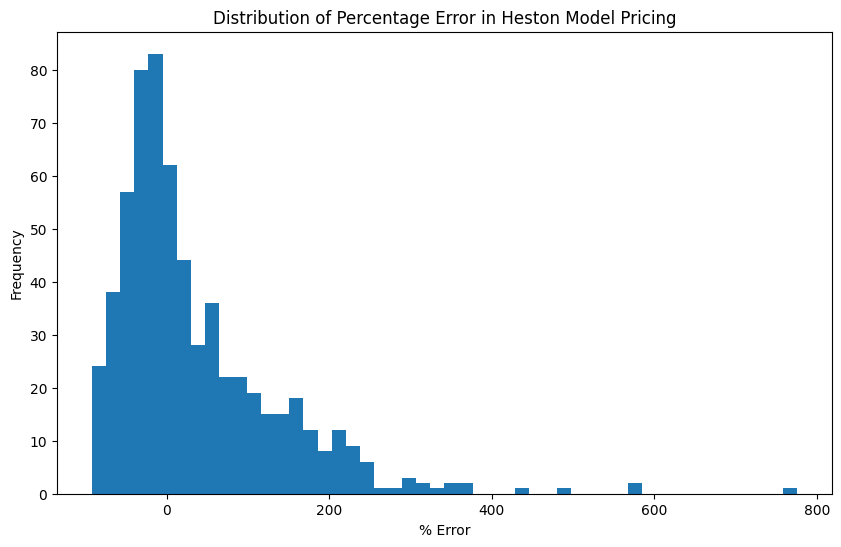

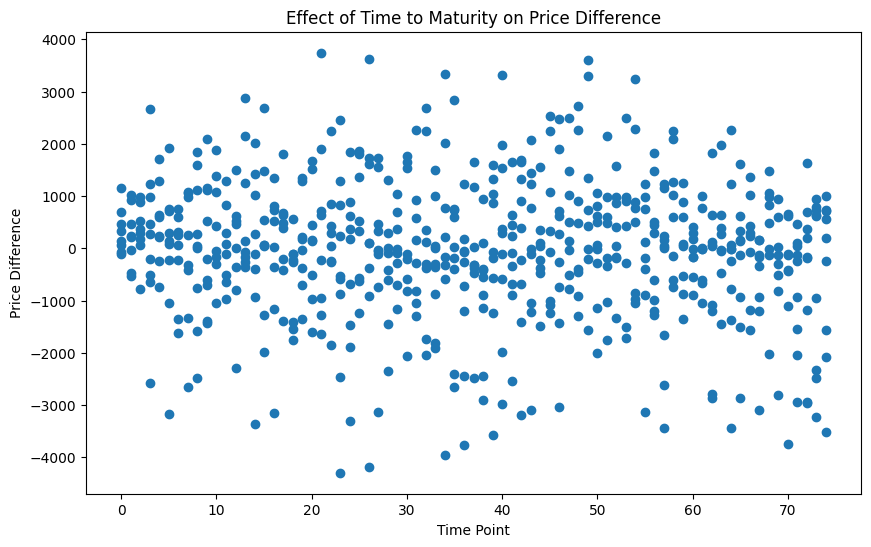

<ipython-input-12-887fd81efb76>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mispricing_freq = df_all.groupby('% Error Bin')['% Error'].count()



Mispricing Patterns by % Error Bins and Frequency:
% Error Bin
(-50, -45]    13
(-45, -40]    17
(-40, -35]    16
(-35, -30]    31
(-30, -25]    22
(-25, -20]    25
(-20, -15]    26
(-15, -10]    25
(-10, -5]     19
(-5, 0]       21
(0, 5]        14
(5, 10]       21
(10, 15]      13
(15, 20]      12
(20, 25]      14
(25, 30]      12
(30, 35]       7
(35, 40]       9
(40, 45]       9
Name: % Error, dtype: int64


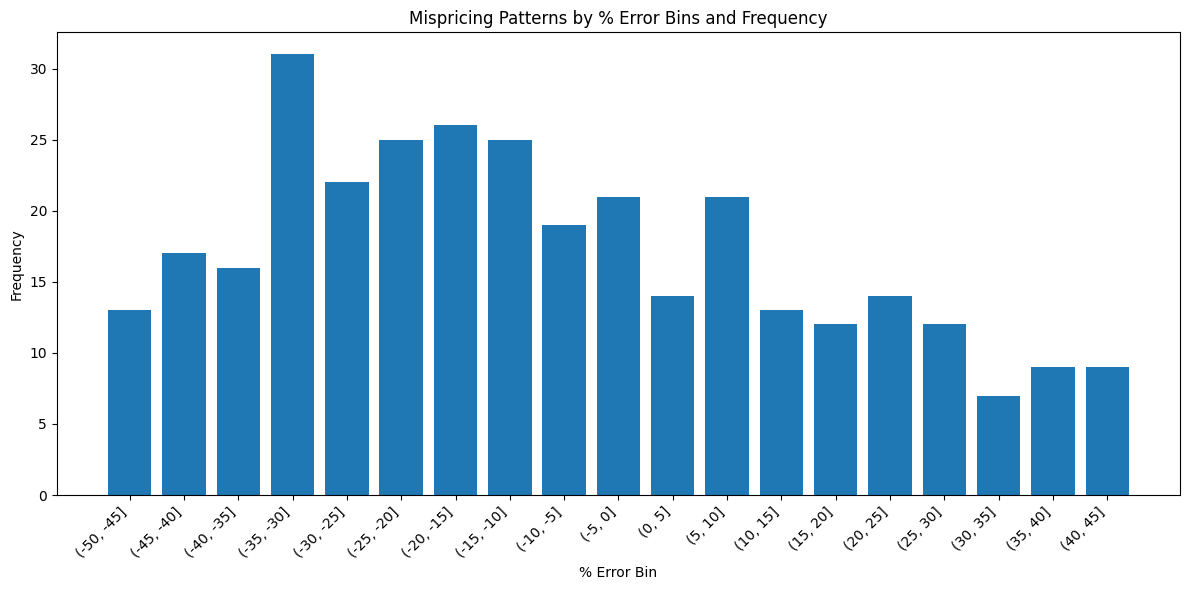

In [ ]:
# prompt: analyse this data statistically, in different ways, for example how much is the error between the heston price and the actual price, sensitivity analysis of parameters on the price, how do parameters affect the price, how does time to maturity affect prices and mispricing patterns ; and how does volatility affect them , , give a comprehensive analysis, also analyse how many prices the model overestimates, how many it underestimates, and also give data for how many have % error in mispricing and its frequency

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the Excel file
df_all = pd.read_excel('heston_comparison_all_data.xlsx')

# Calculate the pricing error
df_all['Price Difference'] = df_all['Heston Price'] - df_all['Actual Price']
df_all['% Error'] = (df_all['Price Difference'] / df_all['Actual Price']) * 100

# 1. Overall Pricing Error Statistics
print("Overall Pricing Error Statistics:")
print(df_all['Price Difference'].describe())
print(f"Mean Absolute Error (MAE): {df_all['Price Difference'].abs().mean()}")

# 2. Overestimation vs. Underestimation
overestimates = len(df_all[df_all['Price Difference'] > 0])
underestimates = len(df_all[df_all['Price Difference'] < 0])
print(f"\nOverestimations: {overestimates} ({(overestimates/len(df_all))*100:.2f}%)")
print(f"Underestimations: {underestimates} ({(underestimates/len(df_all))*100:.2f}%)")


# 3. % Error Distribution
print("\n% Error Distribution:")
print(df_all['% Error'].describe())

# Plot histogram of percentage error
plt.figure(figsize=(10, 6))
plt.hist(df_all['% Error'], bins=50)
plt.xlabel("% Error")
plt.ylabel("Frequency")
plt.title("Distribution of Percentage Error in Heston Model Pricing")
plt.show()



# 5. Time to Maturity Effect
plt.figure(figsize=(10, 6))
plt.scatter(df_all['Time Point'], df_all['Price Difference'])
plt.xlabel('Time Point')
plt.ylabel('Price Difference')
plt.title('Effect of Time to Maturity on Price Difference')
plt.show()

# Group data by 'Test Series Index' to analyze each series
grouped = df_all.groupby('Test Series Index')


# Mispricing patterns by % error bins and frequency:
bins = np.arange(-50, 50, 5)  # Adjust the bin size and range as needed
df_all['% Error Bin'] = pd.cut(df_all['% Error'], bins=bins)
mispricing_freq = df_all.groupby('% Error Bin')['% Error'].count()
print("\nMispricing Patterns by % Error Bins and Frequency:")
print(mispricing_freq)

# Visualize mispricing patterns by % error bins
plt.figure(figsize=(12, 6))
plt.bar(mispricing_freq.index.astype(str), mispricing_freq.values) # Convert index to string
plt.xlabel("% Error Bin")
plt.ylabel("Frequency")
plt.title("Mispricing Patterns by % Error Bins and Frequency")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# prompt: further generate an excel sheet containing data such as mse of all parameters, mse of model, number of overestimation , underestimation, mean % error, mean absolute error, and so on and download the excel sheet with the name which is the title of this notebook

import pandas as pd
import numpy as np
import os

# Assuming df_all is your DataFrame from the previous code

# Create a dictionary to store the results
results_dict = {}

# Overall Statistics
results_dict['Overall Statistics'] = df_all[['Price Difference', '% Error']].describe().to_dict()

# Overestimation vs. Underestimation
results_dict['Overestimations'] = len(df_all[df_all['Price Difference'] > 0])
results_dict['Underestimations'] = len(df_all[df_all['Price Difference'] < 0])

# Mean Absolute Error
results_dict['Mean Absolute Error'] = np.mean(np.abs(df_all['Price Difference']))


# Mean Percentage Error (ignoring NaN values)
results_dict['Mean % Error'] = np.nanmean(df_all['% Error'])

# MSE of all parameters
mse_per_parameter = np.mean((ensemble_predictions - params_test) ** 2, axis=0)
parameter_names = ['alpha', 'eta', 'nu', 'sigma_nu', 'rho']
results_dict['MSE per Parameter'] = dict(zip(parameter_names, mse_per_parameter))

# MSE of model
results_dict['Ensemble Model MSE'] = ensemble_loss

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame([results_dict])


# Get the notebook title (replace with your actual method if needed)
notebook_title = "07 AUGUST"  # Replace with a method to get the notebook title


# Save the DataFrame to an Excel file with the notebook title
output_filename = f'{notebook_title}.xlsx'
results_df.to_excel(output_filename, index=False)

# Download the Excel file
from google.colab import files
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>